# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

In [7]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'rice_export_amount', 'inflation', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'w

# Model

In [9]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_export_finance = ['hommali_price','hommali_price_index','agri_export_value', 'rice_export_value', 
                    'rice_export_amount', 'pol_rate', 'neer', 'reer','inflation' , 'cpi_rice']


# Adjust X to match the same periods
X = df[xvars_export_finance]

In [10]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 10), (25, 10), (201,), (25,))

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [13]:
label = 'nonglu_price'
df = df[xvars_export_finance + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [14]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 10), (25, 10), (201,), (25,))

In [16]:
# Prediction
y_pred = lr.predict(X_test)

In [17]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 984694.5646
Linear Regression Model RMSE: 992.3178
Linear Regression Model R-squared: 0.1046


In [18]:
# Create Score Dataframe
lr_score = pd.DataFrame(data = {'model': ['Linear'] * 3,
                                   'metric':['MSE','RMSE','R2'],'score':[lr_mse,lr_rmse,lr_r2]})
lr_score

,model,metric,score
0,Linear,MSE,984694.564562
1,Linear,RMSE,992.317774
2,Linear,R2,0.104619


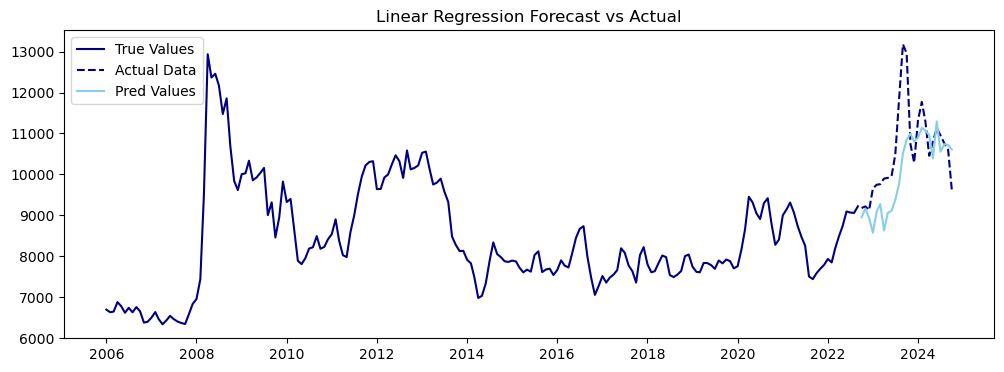

In [19]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/export_finance/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [21]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,hommali_price,0.066977
1,hommali_price_index,0.000872
2,agri_export_value,-0.419752
3,rice_export_value,14.240027
4,rice_export_amount,-0.006731
5,pol_rate,74.526021
6,neer,29.312064
7,reer,-122.391922
8,inflation,42.929296
9,cpi_rice,97.475627


## 2. ARIMA Model

### Model 2 : ARIMA

In [24]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

In [25]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [26]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 766718.4984
ARIMAX(2,1,2) Model RMSE :875.6246
ARIMAX(2,1,2) Model R-squared :0.3028


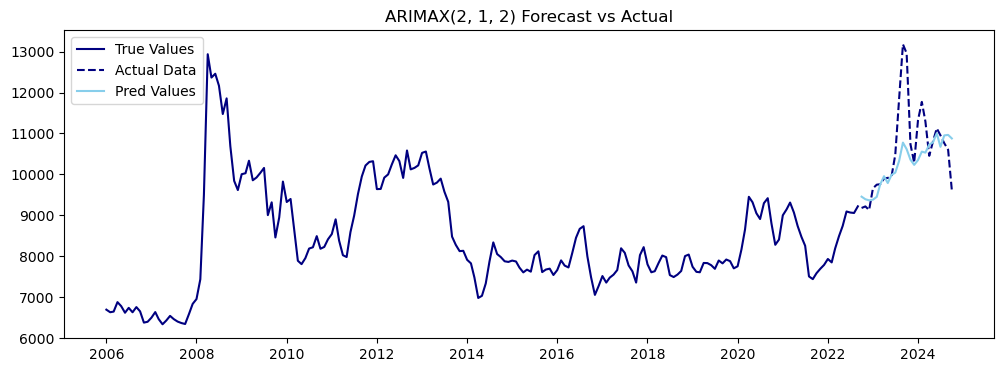

In [27]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/export_finance/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [29]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1460.658
Date:                Thu, 19 Dec 2024   AIC                           2951.315
Time:                        11:20:12   BIC                           3000.790
Sample:                    01-01-2006   HQIC                          2971.337
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
hommali_price           0.1852      0.049      3.766      0.000       0.089       0.282
hommali_price_index     0.0024      0.001      3.720      0.000       0.001       0.004
agri_export_value       0.2501      0.252      0.991      0.322      -0.245       0.745
rice_export_value       2.3307      0.923      2.526      0.012       0.522       4.139
rice_export_amount     -0.0010      0.000     -2.375      0.018      -0.002      -0.000
pol_rate              282.4383    216.737      1.303      0.193    -142.358     707.234
neer                   69.5420    112.116      0.620      0.535    -150.201     289.285
reer                  -87.2080    109.895     -0.794      0.427    -302.599     128.183
inflation              73.7601     92.237      0.800      0.424    -107.022     254.542
cpi_rice               96.1737     13.696      7.022      0.000      69.329     123.018
ar.L1                  -0.8016      1.264     -0.634      0.526      -3.279       1.676
ar.L2                  -0.5486      1.083     -0.506      0.613      -2.672       1.575
ma.L1                   0.7705      1.322      0.583      0.560      -1.820       3.361
ma.L2                   0.5088      1.110      0.458      0.647      -1.667       2.685
sigma2               1.298e+05      0.088   1.47e+06      0.000     1.3e+05     1.3e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                73.02
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+23. Standard errors may be unstable.
"""

### Model 3 : Auto ARIMA

In [31]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        11:20:13   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [32]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [33]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 1038243.7648
ARIMAX(2,0,0) Model RMSE :1018.9425
ARIMAX(2,0,0) Model R-squared :0.0559


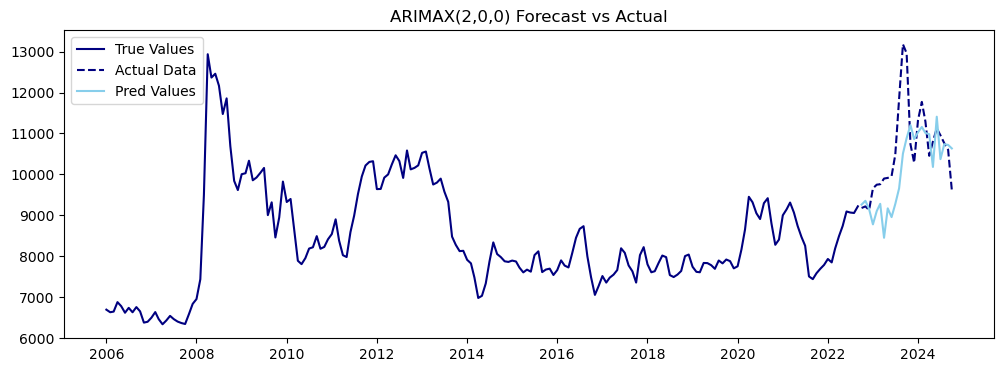

In [34]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/export_finance/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [36]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1517.250
Date:                Thu, 19 Dec 2024   AIC                           3062.501
Time:                        11:20:13   BIC                           3108.747
Sample:                    01-01-2006   HQIC                          3081.214
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.271e+04   3156.629      4.025      0.000    6519.692    1.89e+04
hommali_price           0.0359      0.063      0.575      0.566      -0.087       0.158
hommali_price_index     0.0005        nan        nan        nan         nan         nan
agri_export_value      -0.5148      0.284     -1.816      0.069      -1.070       0.041
rice_export_value      13.9322      1.005     13.867      0.000      11.963      15.901
rice_export_amount     -0.0058      0.000    -13.965      0.000      -0.007      -0.005
pol_rate               74.5258    192.076      0.388      0.698    -301.937     450.989
neer                   29.2997     55.998      0.523      0.601     -80.454     139.053
reer                 -122.4050     65.378     -1.872      0.061    -250.544       5.734
inflation              42.9139     36.816      1.166      0.244     -29.243     115.071
cpi_rice               97.4778     21.579      4.517      0.000      55.184     139.772
ar.L1                   0.8106      0.089      9.107      0.000       0.636       0.985
ar.L2                  -0.0215      0.094     -0.229      0.819      -0.206       0.163
sigma2               2.301e+05     62.360   3689.466      0.000     2.3e+05     2.3e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                88.87
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+20. Standard errors may be unstable.
"""

## 4. GARCH Model

### Model 4 : GARCH

In [39]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [40]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 786222.2865
GARCH Model RMSE :886.6918
GARCH Model R-squared :0.2851


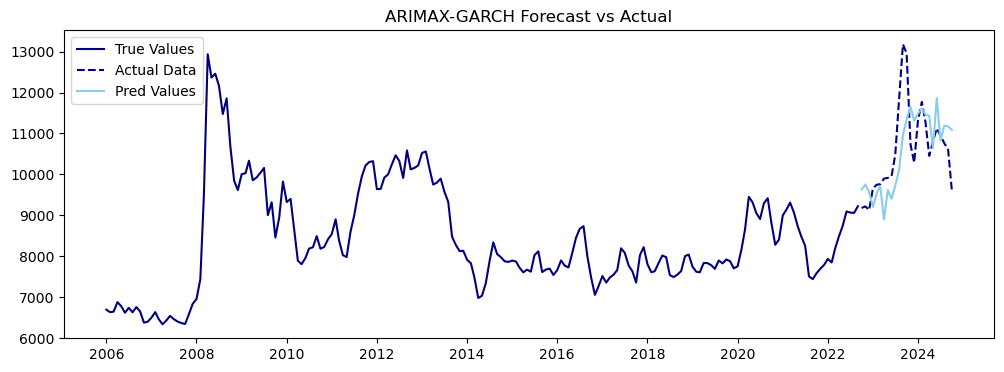

In [41]:
# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/export_finance/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [43]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 63038.82881454492
alpha (ARCH term): 0.20244038074198603
beta (GARCH term): 0.49063695704388555


# Compare the score of models

In [45]:
score_df = pd.DataFrame(data = {'feature' : ['export and finance'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/export_finance.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,export and finance,Linear,9.846946e+05,992.317774,0.104619
1,export and finance,"ARIMAX(2,0,0)",1.038244e+06,1018.942474,0.055926
2,export and finance,GARCH,7.862223e+05,886.691765,0.285089
